# **Practical 5**

Welcome to the last practical for Graph Representation Learning.

We will be implementing the 1-WL hash algorithm that is described in the lectures and testing it on several graphs and GNNs.

The main goal of the practical is creating a working implementation of the 1-WL hash algorithm and understanding its applicability and limitations.

The notebook is divided into sections, each of which comes with complete or partially completed code. Before each snippet of code there will be a description of what we are about to implement. The sections of code you need to complete are marked as Tasks.

Please ensure that you operate within the framework given in the notebook and bring any questions you may have to the practical demonstrators. We suggest that you DO NOT edit code that is a part of the framework, since this will make it more difficult for demonstrators to assist if your code is broken.

In [1]:
# Check PyTorch version installed on this system
!python -c "import torch; print(torch.__version__)"

2.4.0


In [2]:
%%capture
# Download the corresponding PyTorch Geometric module
"""
Assign to TORCH with what you get from the cell above. E.g., export TORCH=1.12.1+cu113
"""
%env TORCH=2.0.1+cu118
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-geometric

In [3]:
import random
import numpy as np
import torch
import torch.nn as nn
from torch_geometric.utils import from_networkx
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import Sequential, GCNConv, global_mean_pool
import networkx as nx
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
rng = np.random.default_rng()

# **Part 1: Weisfeiler Lehman Graph Hash**

## **Task 1.1: Generate graph pairs using NetworkX**

For $n$ between 6 and 15, generate all pairs of graphs $(\mathcal{C_n}, \mathcal{D}_{n,i}))$, where $\mathcal{C}_n$ is a cycle on $n$ nodes and $\mathcal{D}_{n,i}$ is the disjoint union of two cycles, with $n - i$ and $i$ nodes in total (of course the minimum number of nodes in each single connected component you build should be $> 2$). You can use the functions provided by networkx. We suggest you build on top of `networkx.cycle_graph`.

In [6]:
for j in range(3, 6):
    print (j)
for k in range(3, 3):
    print(k)

3
4
5


In [8]:
# The range of different graph sizes
size_range = range(6, 16)

# The list of all graph pairs
graph_pairs = []
Cns = []

for n in size_range:
    Cn = nx.cycle_graph(n)
    
    for i in range(3, n-2): 
        # Generate the two cycle graphs for Dn,i
        Dni_1 = nx.cycle_graph(n - i)  
        Dni_2 = nx.cycle_graph(i)     
        
        # Take the disjoint union
        Dni = nx.disjoint_union(Dni_1, Dni_2)
        
        graph_pairs.append((Cn, Dni))

print(f"Generated {len(graph_pairs)} graph pairs.")


Generated 55 graph pairs.


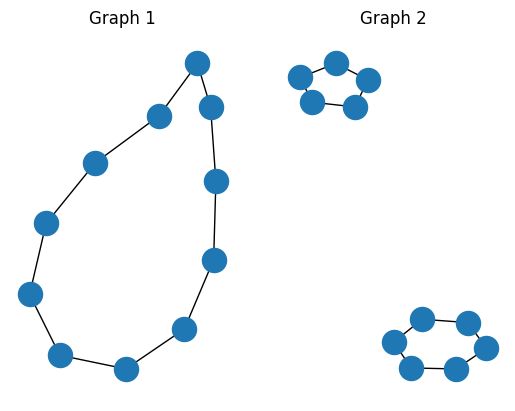

In [9]:
### DO NOT MODIFY

# Display a random pair
fig, axs = plt.subplots(1, 2)
pair = random.choice(graph_pairs)
for i in range(2):
    nx.draw(pair[i], ax=axs[i])
    axs[i].set_title(f"Graph {i+1}")
plt.show()

## **Task 1.2: Implement the Weisfeiler Lehman (WL) graph hash**

Implement the function `weisfeiler_lehman_graph_hash` that takes in input a graph $\mathcal{G}$ and return the hash $WL(\mathcal{G})$. Use the constant $c = 1$ as the label for each node. For this task, you **cannot** use the utilities provided by the networkx library (except to convert from graphs to tensors if necessary).

In [69]:
import hashlib
import networkx as nx

def weisfeiler_lehman_graph_hash(graph, extra_elements = None, max_iter=10):
    
    if(extra_elements == None):
        labels = {node: "1" for node in graph.nodes}
    else:
        labels = {node: "1" + str(extra_elements[node]) for node in graph.nodes}  # accept and extra element degree
    
    
    def hash_label(label):
        return hashlib.md5(label.encode('utf-8')).hexdigest()
    
    for _ in range(max_iter):
        new_labels = {}
        
        for node in graph.nodes:
            neighbor_labels = [labels[neighbor] for neighbor in graph.neighbors(node)]
            combined_label = str(labels[node]) + ''.join(sorted(neighbor_labels))
            new_labels[node] = hash_label(combined_label)

        labels = new_labels
    
    final_labels = sorted(labels.values())
    return hashlib.md5(''.join(final_labels).encode('utf-8')).hexdigest()


Let's do a sanity check to make sure that the members of each pair previously generated are 1-WL indistinguishable:

In [59]:
### DO NOT MODIFY

wl_indistinguishable_pairs = 0
for pair in graph_pairs:
    hash0 = weisfeiler_lehman_graph_hash(pair[0])
    hash1 = weisfeiler_lehman_graph_hash(pair[1])
    wl_indistinguishable_pairs += (hash0 == hash1)

# Print the number of pairs produced
print(f"Number of graph pairs: {len(graph_pairs)}")
print(f"Number of 1-WL indistinguishable pairs: {wl_indistinguishable_pairs}")

Number of graph pairs: 55
Number of 1-WL indistinguishable pairs: 55


# Part 2: WL with extra node information

## **Task 2.1: Updating the hash function**

Modify the `weisfeiler_lehman_graph_hash` to accept an optional extra element corresponding to the features to assign to each node to be used to compute the final hash.

### Task 2.1.1
Use the node degree as initial label to compute the WL hash. What do you expect to change compared to before? Why?

In [62]:
def node_degrees(graph):
  """Returns a list with the degree of each node in graph"""
  list =  {node: str(degree) for node, degree in graph.degree()} # dictionary for (node, degree) pair
  print(list)
  return list


In [64]:
### DO NOT MODIFY

wl_indistinguishable_pairs_with_degree = 0
for pair in graph_pairs:
    hash0 = weisfeiler_lehman_graph_hash(pair[0], node_degrees(pair[0]))
    hash1 = weisfeiler_lehman_graph_hash(pair[1], node_degrees(pair[1]))
    wl_indistinguishable_pairs_with_degree += (hash0 == hash1)

# Print the number of pairs produced
print(f"Number of graph pairs: {len(graph_pairs)}")
print(f"Number of 1-WL indistinguishable pairs when"
      f"using the node degree as label:\n {wl_indistinguishable_pairs_with_degree}")

{0: '2', 1: '2', 2: '2', 3: '2', 4: '2', 5: '2'}
{0: '2', 1: '2', 2: '2', 3: '2', 4: '2', 5: '2'}
{0: '2', 1: '2', 2: '2', 3: '2', 4: '2', 5: '2', 6: '2'}
{0: '2', 1: '2', 2: '2', 3: '2', 4: '2', 5: '2', 6: '2'}
{0: '2', 1: '2', 2: '2', 3: '2', 4: '2', 5: '2', 6: '2'}
{0: '2', 1: '2', 2: '2', 3: '2', 4: '2', 5: '2', 6: '2'}
{0: '2', 1: '2', 2: '2', 3: '2', 4: '2', 5: '2', 6: '2', 7: '2'}
{0: '2', 1: '2', 2: '2', 3: '2', 4: '2', 5: '2', 6: '2', 7: '2'}
{0: '2', 1: '2', 2: '2', 3: '2', 4: '2', 5: '2', 6: '2', 7: '2'}
{0: '2', 1: '2', 2: '2', 3: '2', 4: '2', 5: '2', 6: '2', 7: '2'}
{0: '2', 1: '2', 2: '2', 3: '2', 4: '2', 5: '2', 6: '2', 7: '2'}
{0: '2', 1: '2', 2: '2', 3: '2', 4: '2', 5: '2', 6: '2', 7: '2'}
{0: '2', 1: '2', 2: '2', 3: '2', 4: '2', 5: '2', 6: '2', 7: '2', 8: '2'}
{0: '2', 1: '2', 2: '2', 3: '2', 4: '2', 5: '2', 6: '2', 7: '2', 8: '2'}
{0: '2', 1: '2', 2: '2', 3: '2', 4: '2', 5: '2', 6: '2', 7: '2', 8: '2'}
{0: '2', 1: '2', 2: '2', 3: '2', 4: '2', 5: '2', 6: '2', 7: '2', 

### Task 2.1.2
Modify the initial label of each node $N_i$ such that it now contains the shortest path length from $N_i$ to $N_j$. Run `weisfeiler_lehman_graph_hash` using the new labels.

In [65]:
def node_shortest_paths(graph):
  shortest_paths = {}
    
  for node in graph.nodes():
      shortest_paths[node] = nx.single_source_shortest_path_length(graph, node)
      
  return shortest_paths

In [70]:
### DO NOT MODIFY

wl_indistinguishable_pairs_with_shortest_path = 0
for pair in graph_pairs:
    hash0 = weisfeiler_lehman_graph_hash(pair[0], node_shortest_paths(pair[0]))
    hash1 = weisfeiler_lehman_graph_hash(pair[1], node_shortest_paths(pair[1]))
    wl_indistinguishable_pairs_with_shortest_path += (hash0 == hash1)

# Print the number of pairs produced
print(f"Number of graph pairs: {len(graph_pairs)}")
print(f"Number of 1-WL indistinguishable pairs when"
      f"using the shortest path lenghts as label:\n {wl_indistinguishable_pairs_with_shortest_path}")

Number of graph pairs: 55
Number of 1-WL indistinguishable pairs whenusing the shortest path lenghts as label:
 0


# **Part 3: Building a GNN**

## **Task 3.1: Converting the graphs from Task 1.1 to PyTorch Geometric objects**

Let's turn each graph into `torch_geometric.data.Data` objects, with some input features `x` and output features `y`.
Each previously generated pair should be converted to two Data objects, one for the cycle graph and one for the disjoint union one. The features `x` corresponds to the labels of each node; we will use the same label for each node (e.g., an array of 50 elements each set to 1). The output `y` should be 1 for cycle graphs and 0 for disjoint graphs.

(Look at the function `from_networkx`)

In [108]:
from torch_geometric.data import Data
import torch

# The list to store the Data objects
dataset = []

for pair in graph_pairs:
    for i, graph in enumerate(pair):
        edge_index = torch.tensor(list(graph.edges), dtype=torch.long).t().contiguous()  
        node_features = torch.ones((graph.number_of_nodes(), 50), dtype=torch.float)  # 1 feature per node
        
        label = 1 if i == 0 else 0
        data = Data(x=node_features, edge_index=edge_index, y=torch.tensor([label], dtype=torch.long))
        
        dataset.append(data)

print(dataset[0], dataset[0].y)
print(dataset[1], dataset[1].y)
print(f"Total number of graphs in dataset: {len(dataset)}")


Data(x=[6, 50], edge_index=[2, 6], y=[1]) tensor([1])
Data(x=[6, 50], edge_index=[2, 6], y=[1]) tensor([0])
Total number of graphs in dataset: 110


## **Part 3.2: Defining the model**
Let's define our graph neural network. First, we define a module for doing mean pooling.

In [109]:
class GlobalMeanPool(nn.Module):
    """Global mean pool layer."""

    def forward(self, x, batch=None, size=None):

        # If we don't get the batch vector, set it to zeros.
        if batch is None:
            batch = x.new_zeros(x.size(0), dtype=torch.int64)

        return global_mean_pool(x, batch, size)

This is the base GNN model. The function _layer_sequence specifies the list of modules which define the model.

In [110]:
class GraphSequenceModel(nn.Module):
    """A GNN consisting of a stack of layers."""

    def __init__(self, *args, **kwargs):
        super().__init__()
        sequence = self._layer_sequence(*args, **kwargs)
        self.stack = Sequential("x, edge_index, batch", sequence)

    def forward(self, batch):
        return self.stack.forward(batch.x, batch.edge_index, batch.batch)

    @staticmethod
    def _weight_reset(module):
        if isinstance(module, GCNConv) or isinstance(module, nn.Linear):
            module.reset_parameters()

    def reset_parameters(self):
        return self.stack.apply(type(self)._weight_reset)

Finally, here is the model specification itself:

In [111]:
class MPNN(GraphSequenceModel):
    """An MPNN with a `num_layers` message passing layers, then an MLP."""

    def _layer_sequence(self, num_layers=16): # increase to num_layers = 32 

        # The sequence of layers
        sequence = []

        # Add `num_layers` message passing layers
        for i in range(num_layers):
            sequence.append((GCNConv(50, 50), f"x, edge_index -> x"))
            sequence.append(nn.ReLU())

        # A global mean pool layer
        sequence.append((GlobalMeanPool(), f"x, batch -> x"))

        # Add an MLP at the end
        sequence.extend([
            (nn.Linear(50, 70), "x -> x"),
            nn.ReLU(),
            (nn.Linear(70, 25), "x -> x"),
            nn.ReLU(),
            (nn.Linear(25,2), "x -> x")
        ])

        return sequence

In [121]:
from torch_geometric.nn import GATConv

class GATModel(GraphSequenceModel):
    def _layer_sequence(self, num_layers=4):
        sequence = []
        for i in range(num_layers):
            sequence.append((GATConv(50, 50), f"x, edge_index -> x"))
            sequence.append(nn.ReLU())
        sequence.append((GlobalMeanPool(), f"x, batch -> x"))
        sequence.extend([
            (nn.Linear(50, 70), "x -> x"),
            nn.ReLU(),
            (nn.Linear(70, 25), "x -> x"),
            nn.ReLU(),
            (nn.Linear(25, 2), "x -> x")
        ])
        return sequence
    
class MPNN2(GraphSequenceModel):
    """An MPNN with a `num_layers` message passing layers, then an MLP."""

    def _layer_sequence(self, num_layers=16): # increase to num_layers = 32 

        # The sequence of layers
        sequence = []

        # Add `num_layers` message passing layers
        for i in range(num_layers):
            sequence.append((GCNConv(50, 50), f"x, edge_index -> x"))
            sequence.append(nn.ReLU())

        # A global mean pool layer
        sequence.append((GlobalMeanPool(), f"x, batch -> x"))

        # Add an MLP at the end
        sequence.extend([
            (nn.Linear(50, 70), "x -> x"),
            nn.ReLU(),
            (nn.Linear(70, 25), "x -> x"),
            nn.ReLU(),
            (nn.Linear(25,2), "x -> x")
        ])

        return sequence


Let's now instantiate the model:

In [122]:
model1 = MPNN(num_layers=16).to(device)
model2 = MPNN2(num_layers = 16).to(device)

## **Part 3.3: Training, testing and cross-validation functions**
This is the generic training loop, which does one epoch-worth of training:


In [113]:
def train_epoch(dataloader, model, loss_fn, optimiser):
    """Do one epoch-worth of training."""

    # Put the model in training mode
    model.train()

    # The number of datapoints
    size = len(dataloader.dataset)

    # Loop over each batch of datapoints
    for data in dataloader:

        # Set all the gradients to zero
        optimiser.zero_grad()

        # Make a prediction using the current parameters
        pred = model(data)

        # Compute the loss for this prediction
        loss = loss_fn(pred, data.y)

        # Propagate the loss backwards to compute the gradients
        loss.backward()

        # Do one step of optimisation
        optimiser.step()

This function does a full train on the data:

In [114]:
def train(train_dataloader, test_dataloader, model, loss_fn, optimiser,
          epochs=200, output_every=20):
    """Train a model for a certain number of epochs."""

    # Loop through the epochs
    for t in range(1, epochs+1):

        # Do the training for this epoch
        train_epoch(train_dataloader, model, loss_fn, optimiser)

        # Output the accuracy of the model every so often
        if output_every is not None and t % output_every == 0:
            print(f"Epoch {t}")
            print("----------------------------")
            print(f"Train accuracy: {test(train_dataloader, model):%}")
            print(f"Test accuracy: {test(test_dataloader, model):%}")
            print()

This function tests the model on the data, and returns the accuracy:

In [115]:
def test(dataloader, model):
    """Test a model on some data."""

    # Put the model in evaluation mode
    model.eval()

    # Get the number of datapoints
    size = len(dataloader.dataset)

    # The number of correct predictions
    correct = 0

    # We don't want to be computing the gradients
    with torch.no_grad():

        # Loop through the minibatches
        for data in dataloader:

            # Compute the model predictions
            pred = model(data)

            # Update with the number of correct predictions
            correct += (pred.argmax(1) == data.y).count_nonzero()

    # Compute the accuracy for the whole dataset and return it
    return correct / len(dataloader.dataset)

This function performs cross-validation on the dataset:

In [116]:
import numpy as np
import torch
from torch_geometric.data import DataLoader

def cross_validate(dataset, model, loss_fn, optimizer, num_splits=5, batch_size=32, epochs=200, output_every=20):
    """Use k-fold cross validation to evaluate a model on a dataset."""
    
    # Get the number of graphs
    size = len(dataset)

    # Ensure dataset size is even. If odd, we can drop one pair or handle it differently
    if size % 2 != 0:
        print(f"Warning: Dataset size ({size}) is odd. Dropping one graph.")
        dataset = dataset[:-1]  # Drop the last graph if the dataset size is odd

    num_pairs = size // 2  # Each pair consists of two graphs

    # Construct a permuter which keeps paired graphs together
    pair_permuter = np.random.permutation(np.arange(num_pairs)) * 2  # Multiply by 2 for pairs

    graph_permuter = np.empty((size,), dtype=int)
    graph_permuter[0::2] = pair_permuter
    graph_permuter[1::2] = pair_permuter + 1

    # Use the permuter to shuffle the dataset
    shuffled_dataset = [dataset[i] for i in graph_permuter]

    # Arrays to store the train and test accuracies for each fold
    train_accuracies = np.zeros(num_splits)
    test_accuracies = np.zeros(num_splits)

    # Loop over the folds
    for fold in range(num_splits):
        print(f"Fold {fold + 1}")
        print("============================")
        print()

        # Calculate the current fold segment indices
        index_min = int(((num_pairs * fold) // num_splits) * 2)
        index_max = int(((num_pairs * (fold + 1)) // num_splits) * 2)

        # Split into train and test datasets
        train_dataset = shuffled_dataset[:index_min] + shuffled_dataset[index_max:]
        test_dataset = shuffled_dataset[index_min:index_max]

        # Turn these into torch_geometric dataloaders
        train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
        test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

        # Reset the parameter of the model before training
        model.reset_parameters()

        # Train with these
        train(train_dataloader, test_dataloader, model, loss_fn, optimizer, epochs, output_every)

        # Record the test and train accuracies for the trained model
        train_accuracies[fold] = test(train_dataloader, model)
        test_accuracies[fold] = test(test_dataloader, model)

    # Print the Train and test accuracies for each fold
    print(f"{num_splits}-fold validation summary")
    print("============================")
    for fold in range(num_splits):
        print(f"Fold {fold + 1}. Train: {train_accuracies[fold]:09.5%} Test: {test_accuracies[fold]:09.5%}")


## Task 3.4: Training the model

Specify loss and optimiser and train the model using the `cross_validate` function. Use a learning rate of 1e-3 and 100 epochs. What results do you get? Is it possible to improve the architecture to get a better test accuracy? Why?

In [117]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=1e-3)

# Perform cross-validation
cross_validate(
    dataset=dataset, 
    model=model1, 
    loss_fn=loss_fn, 
    optimizer=optimizer, 
    num_splits=5, 
    batch_size=32,
    epochs=100,  
    output_every=20  
)


Fold 1

Epoch 20
----------------------------
Train accuracy: 50.000000%
Test accuracy: 50.000000%

Epoch 40
----------------------------
Train accuracy: 73.863637%
Test accuracy: 86.363637%

Epoch 60
----------------------------
Train accuracy: 50.000000%
Test accuracy: 50.000000%

Epoch 80
----------------------------
Train accuracy: 68.181819%
Test accuracy: 63.636363%

Epoch 100
----------------------------
Train accuracy: 92.045456%
Test accuracy: 86.363637%

Fold 2

Epoch 20
----------------------------
Train accuracy: 75.000000%
Test accuracy: 81.818181%

Epoch 40
----------------------------
Train accuracy: 50.000000%
Test accuracy: 50.000000%

Epoch 60
----------------------------
Train accuracy: 50.000000%
Test accuracy: 50.000000%

Epoch 80
----------------------------
Train accuracy: 77.272725%
Test accuracy: 63.636363%

Epoch 100
----------------------------
Train accuracy: 84.090906%
Test accuracy: 68.181819%

Fold 3

Epoch 20
----------------------------
Train accuracy: 

In [120]:
# try to increase the model depth
optimizer = torch.optim.Adam(model1.parameters(), lr=1e-3)

# Perform cross-validation
cross_validate(
    dataset=dataset, 
    model=model1, 
    loss_fn=loss_fn, 
    optimizer=optimizer, 
    num_splits=5, 
    batch_size=32,
    epochs=100,  
    output_every=20  
)

Fold 1

Epoch 20
----------------------------
Train accuracy: 97.727275%
Test accuracy: 95.454544%

Epoch 40
----------------------------
Train accuracy: 97.727275%
Test accuracy: 95.454544%

Epoch 60
----------------------------
Train accuracy: 97.727275%
Test accuracy: 95.454544%

Epoch 80
----------------------------
Train accuracy: 92.045456%
Test accuracy: 86.363637%

Epoch 100
----------------------------
Train accuracy: 75.000000%
Test accuracy: 68.181819%

Fold 2

Epoch 20
----------------------------
Train accuracy: 50.000000%
Test accuracy: 50.000000%

Epoch 40
----------------------------
Train accuracy: 50.000000%
Test accuracy: 50.000000%

Epoch 60
----------------------------
Train accuracy: 77.272725%
Test accuracy: 77.272725%

Epoch 80
----------------------------
Train accuracy: 92.045456%
Test accuracy: 86.363637%

Epoch 100
----------------------------
Train accuracy: 96.590906%
Test accuracy: 86.363637%

Fold 3

Epoch 20
----------------------------
Train accuracy: 